# Flat Clustering (K-Means)
---
**Learning notes**
- K-means works on minimizing the Variance of the clusters. Therefore, it works son Euclidean distances to the center. 
- The basic idea of k-means is to minimize squared errors. There is no "distance" involved here.   
    Why it is not correct to use arbitary distances: because k-means may stop converging with other distance functions. 
- However, normalized vectors keep a linear relationship between Euclidean Distance and their Cosine. Norm = 2(1-cos())  
  
**K-Medoids**  
- Alternative to K-Means. The medoid is the existing object most central to the cluster. Only needs the pairwise distances.
- It is more robust to noise and outliers because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances.
- A medoid can be defined as the object of a cluster whose average dissimilarity to all the objects in the cluster is minimal, that is, it is a most centrally located point in the cluster.  
  
**Kernel k-Means**  
When you cannot represent a data point as a Euclidean vector, but if you can still calculate (or define) the inner product between two data points then you can kernelize the algorithm
- Alternative to K-Means. The calculation of distance, kernel method is used instead of the Euclidean distance.
- Algorithm is able to identify the non-linear structures.

## Env Preparation

In [1]:
import os
import sys
print(os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data Preparation

In [5]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l))
data.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


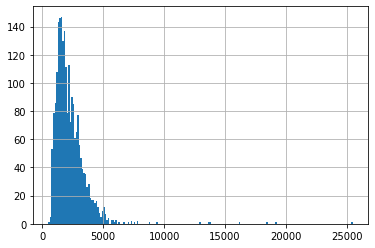

In [6]:
data['lenght'].hist(bins=200)

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [8]:
#### Test on a sample of the data

In [9]:
sample = data.iloc[:2,:]
sample.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842


In [10]:
sample['processed'] = sample['text'].apply(nlp).apply(spacy_cleaning)

In [11]:
print(sample['text'][0][:1000])

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [12]:
print(sample['processed'][0][:1000])

tv future hand viewer home theatre system plasma high definition tv digital video recorder move living room way people watch tv different year time accord expert panel gather annual consumer electronic discuss new technology impact favourite pastime lead trend programme content deliver viewer home network cable satellite telecom company broadband service provider room portable device talk technology ce digital personal video recorder set box system allow people record store play pause forward wind tv programme want technology allow personalise tv build high definition tv set big business lack high definition programming people wind advert forget abide network channel schedule put la carte entertainment network cable satellite company worried mean term advertising revenue brand identity loyalty channel lead technology moment concern raise grow uptake service happen today month year time futurologist tell website like issue lose advertising revenue pressing issue moment commercial broadc

In [15]:
import time
start = time.time()
data['processed'] = data['text'].apply(nlp).apply(spacy_cleaning)
finish = time.time()
print('Done! It took me ', (finish-start))
data.to_csv(JP('data','bbc-text-processed.csv'))
data.head()

Done! It took me  148.99441599845886


,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,4333,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,1842,leave book accuse oversee 11bn fraud accountin...
2,sport,tigers wary of farrell gamble leicester say ...,1342,tiger leicester rush make bid decide switch co...
3,sport,yeading face newcastle in fa cup premiership s...,2176,face trip ryman leader yeade round game highli...
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579,raid crime star go number office take m m week...


In [4]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,4333,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,1842,leave book accuse oversee 11bn fraud accountin...
2,sport,tigers wary of farrell gamble leicester say ...,1342,tiger leicester rush make bid decide switch co...
3,sport,yeading face newcastle in fa cup premiership s...,2176,face trip ryman leader yeade round game highli...
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579,raid crime star go number office take m m week...


## TFIDF

In [5]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = 50
print(NUM_CLUSTERS)

5


In [7]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

In [8]:
tfidf = vectorizer.fit_transform(data['processed'].copy())
tfidf_df = pd.DataFrame(
    tfidf.toarray(), columns=vectorizer.get_feature_names())
print(tfidf_df.shape)
tfidf_df.head()

(2225, 168)


,able,accord,action,add,allow,analyst,announce,ask,base,believe,...,turn,use,want,way,website,week,win,work,world,year
0,0.000,0.065,0.000,0.048,0.134,0.000,0.071,0.000,0.000,0.000,...,0.000,0.000,0.356,0.104,0.073,0.000,0.000,0.051,0.000,0.067
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.178,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.389,...,0.000,0.194,0.000,0.163,0.000,0.165,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.129,0.000,0.000,0.000
4,0.000,0.149,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.122,0.113,0.000,0.000,0.000


## Moving to a Catalog Format

In [9]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [10]:
catalog = Catalog()
catalog.documents = documents

In [11]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 168)


,able,accord,action,add,allow,analyst,announce,ask,base,believe,...,turn,use,want,way,website,week,win,work,world,year
0,0.000,0.065,0.000,0.048,0.134,0.000,0.071,0.000,0.000,0.000,...,0.000,0.000,0.356,0.104,0.073,0.000,0.000,0.051,0.000,0.067
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.178,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.389,...,0.000,0.194,0.000,0.163,0.000,0.165,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.129,0.000,0.000,0.000
4,0.000,0.149,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.122,0.113,0.000,0.000,0.000


**We actually have already a vocab in our Model instance**

In [12]:
[ (k,v) for i,(k,v) in enumerate(tfidf.token2id.items()) if i<5 ]

[('future', 49), ('hand', 61), ('home', 68), ('system', 147), ('high', 65)]

## Clustering

In [13]:
from sklearn.cluster import KMeans

def kmean_clustering(
    model, # class Model
    num_clusters:int=4,
    njobs=-1,
    random_state=46):
    '''
    TODO: Consider MiniBatchKMeans
    Args:
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for

    Returns: 
        - Clustering model instance
    '''
    km = KMeans(
        n_clusters=num_clusters,
        n_jobs=njobs,
        random_state=random_state)
    return km.fit(model.representation)
    
def j_words_per_cluster(
    model,
    clusters:KMeans,
    words_per_cluster:int=None):
    '''
    Return the j most important words per cluster
        The k closest to the centroid of that cluster
        Equivalently: the words are the ones most present in the 'fake'
        document represented by the centroid of the cluster

    Args:
        - Clustering model instance
    
    Returns:
        - Dict key='cluster id', value=k_words_closest_to_centroid
    '''
    
    # 1. Bring K most similar words to centroid
    closests_words_to_centroids = clusters.cluster_centers_.argsort()[:, words_per_cluster:-1] 
    
    # 3. Create a dictionary {'cluster_id': 'important_words'}
    cluster_words = defaultdict(list)
    for i in range(len(clusters.cluster_centers_)):
        for idx in closests_words_to_centroids[i, :words_per_cluster]:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [14]:
## CALCULATE ALL IN ONE STEP
clusters = kmean_clustering(model=tfidf, num_clusters=NUM_CLUSTERS)
cluster_words = j_words_per_cluster(tfidf,clusters,6)

In [15]:
def filter_cluster(model, clusters, i):
    ''' Returns the tfidf representation for the centroid of a cluster '''
    return pd.DataFrame(
        clusters.cluster_centers_[i].reshape(1,-1), 
        columns=model.representation.columns)

In [16]:
cluster0 = filter_cluster(tfidf, clusters, 0)
cluster0.head()

,able,accord,action,add,allow,analyst,announce,ask,base,believe,...,turn,use,want,way,website,week,win,work,world,year
0,0.020,0.025,0.025,0.035,0.031,0.010,0.020,0.026,0.029,0.025,...,0.019,0.050,0.043,0.038,0.034,0.032,0.016,0.056,0.039,0.072


In [17]:
cluster_words

defaultdict(list,
            {0: ['half', 'analyst', 'feel', 'team', 'game', 'film'],
             1: ['happen', 'star', 'team', 'film', 'man', 'play'],
             2: ['share', 'system', 'rise', 'suggest', 'state', 'demand'],
             3: ['sell', 'star', 'half', 'industry', 'film', 'release'],
             4: ['party', 'government', 'level', 'match', 'half', 'leader']})

In [18]:
cluster0[cluster_words[0]+cluster_words[1]]

,half,analyst,feel,team,game,film,happen,star,team,film,man,play
0,0.009,0.010,0.011,0.011,0.011,0.011,0.015,0.016,0.011,0.011,0.025,0.016


## What is the importance of each word within the cluster?   

### Q1: SHOULD WE USE CLUSTER 'FAKE DOCUMENT' INFORMATION OR REAL DOCUMENTS INFORMATION?

- **ALTERNATIVE 1**: Use the centroid as a document that comprises the information of all the documents related to them.  
- **ALTERNATIVE 2**: Use the information of the real documents to determine the importance of a word.    


### Case Alternative 2
Different combinations of the TF with the IDF for each word to compute a single number.    
  
  
### Q2: FOR ALTERIATIVE 2 SHOULD THE TF BE REDUCED TO ONLY THOSE DOCS OF THE CLUSTER???   
For the case where I use all the documents, each word is now a vector representation.  
 - **CASE 2.1** TF WOULD BE docs_in_cluster LONG VECTOR
 - **CASE 2.2** TF WOULD BE total_docs LARGE VECTOR

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
methods = score_cols = ['idf','max_tf_idf','avg_tf_idf','norm_tf_idf']

### CASE 1: USING THE CENTROID
We understand the centroid of a cluster as the 'fake' document which aggregates the information about all the documents in the cluster.  
The importance of the word is given by the value of the vector representing the document in the at the word_index.

In [20]:
cluster_words = j_words_per_cluster(tfidf,clusters,None)

In [21]:
def compute_word_importance_for_centroid(cluster,words_per_cluster):
    ''' Return the first (words_per_cluster) with the highest TFIDF score
    for the centroid of that cluster as a cluster summary document '''
    scores = pd.DataFrame(cluster.T.reset_index())
    scores.columns=['word','centroid_score']
    return scores.sort_values(by='centroid_score',ascending=False)[:words_per_cluster]

In [22]:
centroid_scores = compute_word_importance_for_centroid(cluster0, WORDS_PER_CLUSTER)
print(centroid_scores.shape)
centroid_scores.head()

(50, 2)


,word,centroid_score
108,people,0.101
167,year,0.072
101,new,0.068
55,government,0.065
99,music,0.060


### CASE 2: USING THE DOCUMENTS 
We move to document space.  
Now, each word is a vector in the document space.  

We have the possibility of using the information of the word in the entire corpus and then filtering by appearing among the docuemnts in the cluster.  
We are saying, the importance of a word is giving by the entire corpus. Now that would be the word for this cluster if it appears in it.  

Alternatively, we could first filter by droping the rows corresponding to the documents outside the cluster.  
This way we reduce space for each of the words.  

In [23]:
from copy import deepcopy

def subsample_tfidf_by_cluster(tfidf:pd.DataFrame, clusters:KMeans, cluster_id:int):
    ''' Returns a sample of the TFIDF keeping only the documents (rows) that belong to a particular cluster '''
    return tfidf.loc[clusters.labels_==cluster_id]

def subsample_tfidf_by_terms(tfidf:pd.DataFrame, words):
    ''' Return a sample version of a TFIDF for the words of a cluster 
    NOTE: This function implmented compute_word_importance()'''
    return tfidf[words]

def cluster_to_tfidf(model, clusters:KMeans, cluster_id:int):
    submodel = deepcopy(model)
    submodel.representation = subsample_tfidf_by_cluster(model.representation, clusters, cluster_id)
    return submodel

def get_tf_idf_of_word_from_tfidf_matrix(model,k,v):
    ''' Get the TF vector and IDF float of an specific term '''
    return model.representation[[k]].values, model.mapping.idf_[v]

def compute_word_importance_using_documents(model, words_of_cluster=None):
    ''' Compute the importance of a word given the TFIDF for a bunch of
    importance methods '''
    scores = defaultdict(list)
    if not words_of_cluster: words_of_cluster = model.token2id.keys()
    print('[INFO]: Computing word importance for each cluster')
    for k,v in model.token2id.items():
        # With this comparison we save a lot of time
        if k in words_of_cluster:
            scores['word'].append(k)
            t,i = get_tf_idf_of_word_from_tfidf_matrix(model,k,v)
            scores['idf'].append(i)
            scores['max_tf_idf'].append(np.max(t)) 
            scores['avg_tf_idf'].append(np.mean(t))
            scores['norm_tf_idf'].append(np.linalg.norm(t))
    return scores

def sort_scores(scores, method:str='idf'):
    err = lambda d,ds: '[ERROR]: Score method {} not among {}'.format(d,ds)
    assert method in scores.keys(), err(method, scores.keys())
    return pd.DataFrame(scores).sort_values(method,ascending=False)

#### CASE 2.1: SUBSAMPLING THE TF BY CLUSER

In [24]:
tfidf_cluster_0 = cluster_to_tfidf(tfidf, clusters, 0)

In [25]:
subsample_scores = compute_word_importance_using_documents(tfidf_cluster_0)

[INFO]: Computing word importance for each cluster


In [34]:
def plot_scores_by_methods(
    scores:list,
    max_words:int=5, n_cols=3):

    j = 1 if len(scores)%n_cols != 0 else 0
    n_rows = len(scores)//n_cols + j 
    _, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=(n_cols*5,n_rows*5))
        
    for c, (method, values) in enumerate(scores.items()):
        words = scores_by_method[method].word[:10]
        scores_by_method[method]\
            .loc[:,['word',method]][:10].set_index('word')\
            .plot.bar(
                rot =45, width=0.8, title=method.upper(), legend=False,
                ax=axs[c // n_cols, c % n_cols])
        
        # Extra config to the axis
        # axs[c // n_cols, c % n_cols].axis()
    #plt.tight_layout()
    plt.show()
    return

In [51]:
def define_subplots(n_cols,n_plots):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    _, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=(n_cols*5,n_rows*5))

    # Testing indexing
    for c in range(5):
        print(c // n_cols, c % n_cols)
        
    return axs

# # TEST
# axs = define_subplots(3,5)
# plt.tight_layout()
# plt.show()

In [52]:
def plot_scores_by_methods(
    scores:list,
    max_words:int=5, n_cols=3):

    axs = define_subplots(n_cols,len(s))
    print('Cols: {} Rows: {}'.format(axs.shape))
        
    for c, (method, values) in enumerate(scores.items()):
        words = scores_by_method[method].word[:10]
        scores_by_method[method]\
            .loc[:,['word',method]][:10].set_index('word')\
            .plot.bar(
                rot =45, width=0.8, title=method.upper(), legend=False,
                ax=axs[c // n_cols, c % n_cols])
        
        # Plot the resulting wordcloud
        # axs[c // n_cols, c % n_cols].axis()
        
    plt.figsize()
    plt.tight_layout()
    plt.show()
    return

In [55]:
scores_by_method = defaultdict(list)
for method in methods:
    scores_by_method[method] = sort_scores(subsample_scores,method)[:20]

In [56]:
plot_scores_by_methods(scores_by_method, n_cols=1)

NameError: name 's' is not defined

In [35]:
subsmaple_scores_df = pd.DataFrame(subsample_scores)
subsmaple_scores_df = subsmaple_scores_df[subsmaple_scores_df['word'].isin(cluster_words[0])]
subsmaple_scores_df.head(5)

,word,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
0,future,3.088,0.598,0.022,2.061
1,hand,3.283,0.445,0.016,1.631
2,home,2.859,0.582,0.036,2.892
3,system,3.159,0.792,0.048,3.981
4,high,2.808,0.601,0.023,2.010


<IPython.core.display.Javascript object>


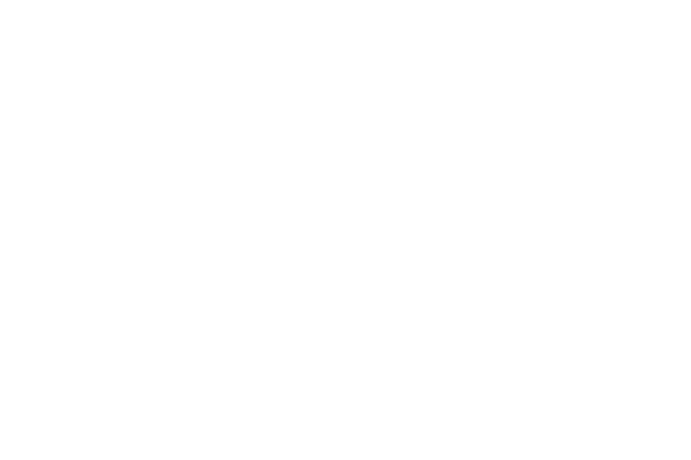

<IPython.core.display.Javascript object>


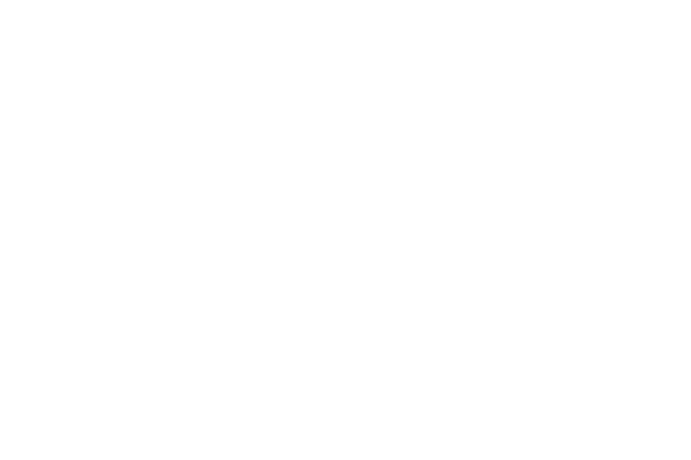

In [36]:
subsmaple_scores_df[score_cols] = st_scaler.fit_transform(X=subsmaple_scores_df[score_cols])
subsmaple_scores_df.set_index('word').iloc[:10].plot.bar(width=0.8)

In [94]:
subsmaple_scores_df[score_cols] = mm_scaler.fit_transform(X=subsmaple_scores_df[score_cols])
subsmaple_scores_df.set_index('word').iloc[:10].plot.bar(width=0.8)subset.plot.bar()

SyntaxError: invalid syntax (<ipython-input-94-6e8172bebf5f>, line 2)

#### CASE 2.2: TAKING INTO ACCOUNT ALL  

In [95]:
scores = compute_word_importance_using_documents(tfidf, cluster_words[0])
scores_df = pd.DataFrame(scores)
scores_df.head()

[INFO]: Computing word importance for each cluster


,word,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
0,future,3.088,0.598,0.018,2.720
1,hand,3.283,0.445,0.015,2.517
2,home,2.859,0.582,0.026,3.627
3,system,3.159,0.792,0.023,4.152
4,high,2.808,0.620,0.023,3.169


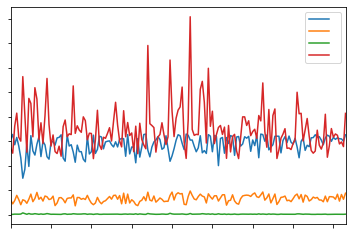

In [96]:
scores_df.plot()

In [97]:
all_scores = pd.merge(centroid_scores, scores_df, left_on='word', right_on='word')
all_scores.head()

,word,centroid_score,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
0,year,0.072,1.493,0.612,0.076,5.643
1,new,0.068,1.975,0.635,0.050,4.754
2,government,0.065,2.532,0.762,0.044,5.450
3,music,0.060,3.274,0.929,0.030,5.386
4,service,0.060,2.879,0.912,0.032,4.727


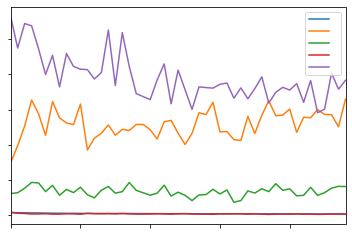

In [98]:
all_scores.plot()

---

---

# Plotting the WordClouds
##### Example Case: Cluster 0

In [99]:
from wordcloud import WordCloud
def cluster_to_wordcloud(
    df, method='idf', max_words=100, use_mask=False):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color="white").generate_from_frequencies(
            frequencies=dict(zip(df.word, df[method])))
    return wordcloud

In [100]:
def plot_centroids_as_wordclouds(
    model,
    clusters:KMeans,
    method:str='centroid_score',
    max_words_per_cloud=100, use_mask=False, n_cols=2):

    n_rows = len(clusters.cluster_centers_)//n_cols
    _, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(n_cols*5,n_rows*5))
    
    for c in range(len(clusters.cluster_centers_)):
        doc = filter_cluster(model,clusters,c)
        cluster_word_scores = compute_word_importance_for_centroid(doc, max_words_per_cloud)
        wordcloud = cluster_to_wordcloud(
            df=cluster_word_scores,
            method=method,
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return

### Alternative 1 - Use centroid as Cluster Information

IndexError: index 2 is out of bounds for axis 0 with size 2

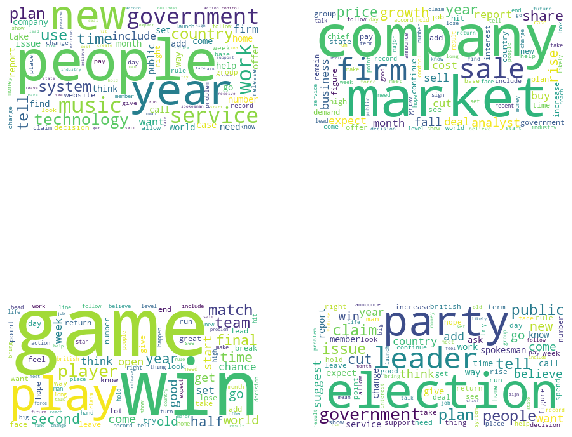

In [101]:
plot_centroids_as_wordclouds(tfidf,clusters)

### Alternative 2.1 - Use information from all documents

In [41]:
subsample = sort_scores(scores, 'norm_tf_idf')
subsample.head()

,word,idf,max_tf_idf,avg_tf_idf,norm_tf_idf
3,include isomer,2.67,0.74,0.05,0.74
2,isomer,1.37,0.38,0.07,0.53
0,carbamate,1.83,0.29,0.06,0.46
1,atom,1.37,0.24,0.06,0.35


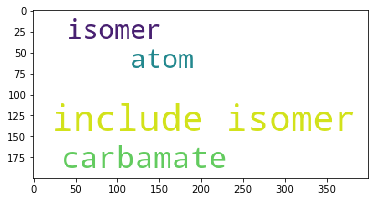

In [42]:
_, ax = plt.subplots()
wordcloud = cluster_to_wordcloud(subsample, method='idf')
ax.imshow(wordcloud)

[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster


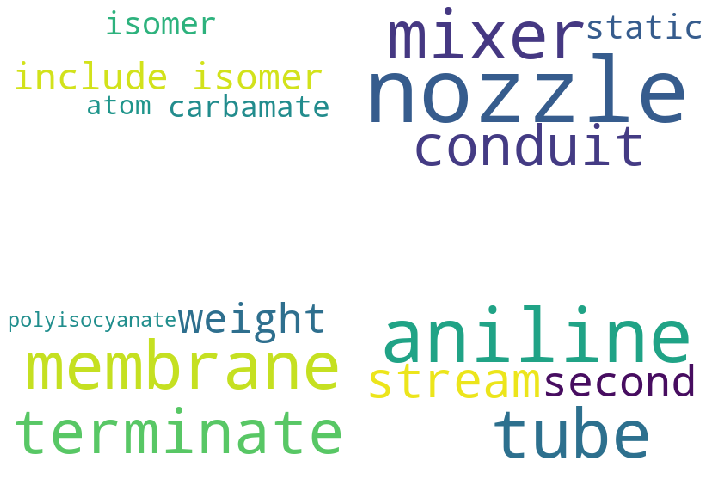

In [43]:
plot_clusters_as_wordclouds(tfidf, cluster_words, method='idf')

### Alternative 2.2 - Use information of the documents of that cluster

[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster
[INFO]: Computing word importance for each cluster


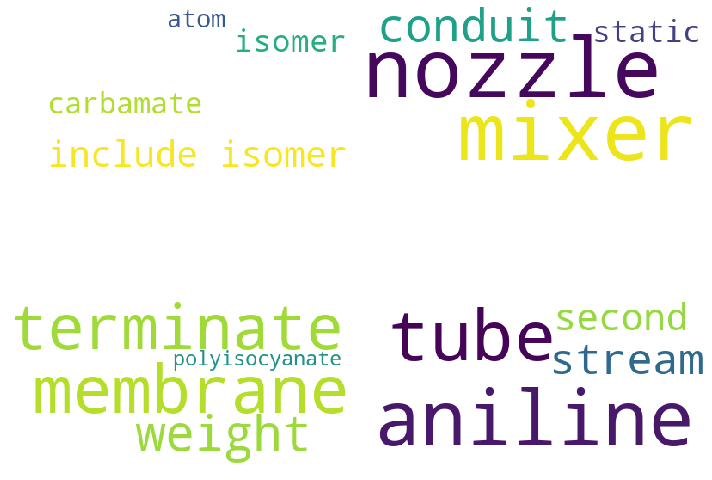

In [108]:
plot_subsampled_clusters_as_wordclouds(tfidf, clusters, cluster_words, method='idf')